# STEP 1

In [6]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import math
import geojson
import numpy as np
from openpyxl import load_workbook


## Functions

### Plot with ColorMaps

In [7]:

def plot_colormaps(line_values,bus_values,trafo_values,load_values,file_name):
    
    line_values=net.res_line.loading_percent
    bus_values=net.res_bus.vm_pu
    trafo_values=net.res_trafo.loading_percent
    load_values=net.res_load.p_mw
    switch_values=net.res_switch.i_ka


    cmap_list_line=[(0, "#00e33e"),(50, "yellow"),  (max_line_loading, "red")]
    cmap_list_bus=[(bus_min_pu, "#00e33e"),(1,"yellow"), (bus_max_pu, "red")]
    cmap_list_trafo=[((0, 80), "#00e33e"), ((80, max_trafo_loading), "yellow"), ((max_trafo_loading, 200), "red")]
    cmap_list_load=[(0, "red"), (0.1, "#00e33e")]

    cmap_line, norm_line = plot.cmap_continuous(cmap_list_line)
    cmap_bus, norm_bus= plot.cmap_continuous(cmap_list_bus)
    cmap_trafo, norm_trafo =plot.cmap_discrete(cmap_list_trafo)
    cmap_load, norm_load = plot.cmap_continuous(cmap_list_load)

    load_colors=cmap_load(norm_load(load_values))

    line_c = plot.create_line_collection(net, net.line.index, z=line_values, zorder=1, cmap=cmap_line, norm=norm_line, linewidths=2)
    bus_c = plot.create_bus_collection(net, net.bus.index, z=bus_values, size=0.2, zorder=2, cmap=cmap_bus, norm=norm_bus)
    trafo_c= plot.create_trafo_collection(net, net.trafo.index, z=trafo_values, zorder=3, cmap=cmap_trafo, norm=norm_trafo)
    load_c = plot.create_load_collection(net, net.load.index, size=0.3, color=load_colors)
    
    plot.draw_collections([line_c, bus_c, trafo_c ,load_c], figsize=(15,8))

    # Custom switch plotting
    for i, switch in net.switch.iterrows():
        bus_idx = switch['bus']
        element_idx = switch['element']
        # Get coordinates (assuming the switch connects a bus to a line or another bus)
        bus_coords = net.bus_geodata.loc[bus_idx]
        if bus_idx==14 or bus_idx==7 or bus_idx==4:
            if switch['closed']==1:
                plt.plot(bus_coords.x, bus_coords.y, 'bx', markersize=15)
            else:
                plt.plot(bus_coords.x, bus_coords.y, 'rx',markersize=15)
                
    plt.savefig(file_name)

### Check Voltage Range

In [8]:
def checkVoltageRange(max,min,vm_data,component_name):
    #print(f'---------{component_name} Voltage Check ---------\n')
    i=0
    faults=0
    for vm in vm_data:
        if vm >= max:
            #print(f'{component_name} {i} Voltage is Over the Limit: {round(vm,4)}')
            faults+=1
        elif vm <= min:
            #print (f'{component_name} {i} Voltage is Under the Limit: {round(vm,4)}')
            faults+=1
        elif math.isnan(vm):
            #print (f'{component_name} {i} is off Grid')
            faults+=1
        i+=1
    """if faults==0:
        print(f'OK {component_name} \n')
    else:
        print(f'Number of {component_name} out of Voltage range: {faults}\n ')"""
    return faults   

### Check Loading Percent

In [9]:
def checkLoadingPercent(limit,loading_data,component_name):
    #print(f'---------{component_name} Loading Check ---------\n')
    i=0
    faults=0
    faults_disc=0
    for loading in loading_data:
        if loading > limit:
            #print(f'{component_name}  {i} is Overloaded: {round(loading,2)}')
            faults+=1
        elif math.isnan(loading):
            #print (f'{component_name} {i} is off Grid')
            faults_disc+=1
        i+=1
    """if faults==0:
        print(f'OK {component_name} loading\n')
    else:
        print(f'Number of Overloaded {component_name} : {faults} \n')
        print(f'Number of disconnected {component_name} : {faults_disc} \n')"""
        
    return faults, faults_disc

### Check Load Power

In [10]:
def load_check(load_data):
    #print(f'----------Loads check ---------\n')
    i=0
    faults=0
    load_status=np.zeros(18)
    for load in load_data:
        if load == 0:
            #print(f'{i} OK')
            load_status[i]=1
            faults+=1
        else:
            load_status[i]=0
        i+=1
    """if faults==0:
        print("OK Loads\n")
    else:
        print(f'Number of not served Loads: {faults}\n')"""
    return faults, load_status

### Excel line data

In [11]:
def excel_values_lines(workbook, sheet_name, column_, data, nan_data,power_data):
     # Load the workbook and select the sheet
     sheet = workbook[sheet_name]
     k=0
     # Start writing data
     for i, value in enumerate(data):
          # Start writing from row 5
          row=i+6

          cell = sheet.cell(row=row, column=column_)
          cell.value = value
          cell =sheet.cell(row=row,column=column_+10)
          cell.value= nan_data[k]
          cell =sheet.cell(row=row,column=column_+20)
          cell.value=power_data[k]
          k=k+1

### Excel load data

In [12]:
def excel_values_load(workbook, sheet_name, column_, data):
     # Load the workbook and select the sheet
     sheet = workbook[sheet_name]

     for i, value in enumerate(data):
          # Start writing from row 5
          row=i+5

          cell = sheet.cell(row=row, column=column_)
          cell.value = value
          #print(f"Writing {value} to cell {cell.coordinate}")

### (N-1)Contingency

In [13]:
def contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,l12,l13,l14,file_path):
    workbook = load_workbook(file_path)
    print("------------------------------------------------------------------------------------------------------------------")
    i=0
    sum_line_loading = np.zeros(15)
    sum_line_power=sum_line_loading
    nan_times=sum_line_loading
    sum_load_status=np.zeros(18)
    excel_column=0 
    match (l12,l13,l14):
        case (1, 1, 1):
             excel_column=2
        case (0, 0, 0):
             net.switch.at[1,'closed']=False
             net.switch.at[2,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[13,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=3  
        case (1, 0, 0):
             net.switch.at[2,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[13,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=4
        case (1, 0, 1):
             net.switch.at[2,'closed']=False
             net.line.at[13,'in_service']=False
             excel_column=5
        case (1, 1, 0):
             net.switch.at[5,'closed']=False
             net.line.at[14,'in_service']=False
             excel_column=6
        case (0, 1, 0):
             net.switch.at[1,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=7
        case (0, 1, 1):
             net.switch.at[1,'closed']=False
             net.line.at[12,'in_service']=False
             excel_column=8
        case (0, 0, 1):
             net.switch.at[1,'closed']=False
             net.switch.at[2,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[13,'in_service']=False
             excel_column=9

    print(f'L12 = {l12} L13 = {l13} L14 = {l14} ') 
    for i,line in net.line.iterrows():
        if i < 12:  
            #Printing Line Index and From-To Buses   
            #print(f'######################## Line {i} ##############################')
            from_bus = line['from_bus']
            to_bus = line['to_bus']
            #print(f'From Bus {from_bus} to {to_bus}')

            #Line i Out of service 
            net.line.at[i,'in_service']=False

            #Run the net
            pp.runpp(net)
            #plot_colormaps(net.res_line.loading_percent,net.res_bus.vm_pu,net.res_trafo.loading_percent,net.res_load.p_mw,f'{l12}{l13}{l14}_Line_{i}.png')
            #Check the values
            faults_voltage=checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
            faults_line, faults_disc_line =checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
            faults_trafo, faults_disc_trafo =checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")
            #print(net.res_trafo.loading_percent)
            #print(net.res_trafo.p_hv_mw)
            faults_load,load_status=load_check(net.res_load.p_mw)
            sum_load_status=sum_load_status+load_status

            #Write on Excel
            sheet = workbook['Line_load']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_line)
            sheet=workbook['Line_disc']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_disc_line)
            sheet = workbook['Bus']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_voltage)
            sheet = workbook['Trafo']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_trafo)
            sheet = workbook['Load']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_load)
            
            nan_times=nan_times+ np.where(np.isnan(net.res_line.loading_percent.to_numpy()), 1, 0)
            #print(f'array = {net.res_line.loading_percent.to_numpy()}')
            #print(f'Nan values= {nan_times}')
            sum_line_loading=sum_line_loading+ np.nan_to_num(net.res_line.loading_percent.to_numpy(), nan=0) 
            sum_line_power=sum_line_power+np.nan_to_num(net.res_line.p_from_mw.to_numpy(), nan=0) 
            
            
            net.line.at[i,'in_service']=True
            i+=1

    avg_line_loading= sum_line_loading/(12-nan_times)
    avg_power_loading=sum_line_power/(12-nan_times)
    #print(f'AVG_LINE_LOADING {avg_line_loading}')
    excel_values_lines(workbook,'Line_Loading',excel_column,avg_line_loading,nan_times, avg_power_loading)
    excel_values_load(workbook, 'Load_status',excel_column,sum_load_status)
    workbook.save(file_path)
    net.switch.at[1,'closed']=True
    net.switch.at[2,'closed']=True
    net.switch.at[5,'closed']=True
    net.line.at[12,'in_service']=True
    net.line.at[13,'in_service']=True
    net.line.at[14,'in_service']=True


SyntaxError: invalid syntax (2029262869.py, line 10)

## 1.1 State of the Network

What is the state of the network? Check bus voltage [pu] and line/transformer loading [%]

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, and the maximum line loading is 100%.

Set the limits for Voltage Per Unit (pu) and for Line loading

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
E:\software\miniconda\lib\site-packages\pandapower\plotting\collections.py:1253: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angle = np.arctan2(vec[1], vec[0])
E:\software\miniconda\lib\site-packages\pandapower\plotting\collections.py:1254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rotation = Affine2D().rotate_around(pos_sw[0], pos_sw[1], angle)
E:\software\miniconda\lib\site-packages\pandapow

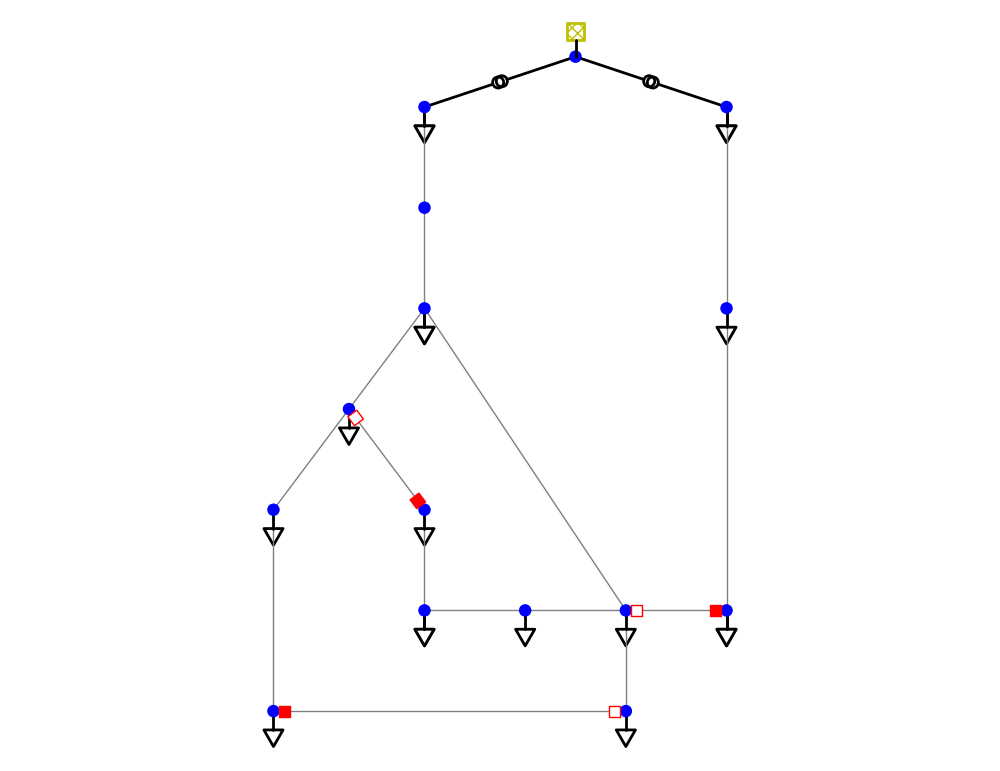

(1, 0)

In [14]:
net = nw.create_cigre_network_mv(with_der=False)

bus_max_pu=1.1
bus_min_pu=0.9
max_line_loading=100
max_trafo_loading=100

pp.runpp(net)
plot.simple_plot(net, respect_switches=False, line_width=1.0, bus_size=1.0, ext_grid_size=1.0, trafo_size=1.0, 
                 plot_loads=True, plot_gens=False, plot_sgens=False, 
                 load_size=2, gen_size=1.0, sgen_size=1.0, 
                 switch_size=2.0, switch_distance=1.0, plot_line_switches=True, scale_size=True, 
                 bus_color='b', line_color='grey', trafo_color='k', ext_grid_color='y', switch_color='r', library='igraph', show_plot=True, ax=None)


checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")

## 1.2 (N-1) Contingency

What happens in the system during a contingency (N-1) case? Are there lines overloaded? Buses above/under the limits?

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, the maximum line loading is 100% AND all
customers/loads should be supplied with power.

Ignore the switches:
- Line 12 (bus 6 to 7)
- Line 13 (bus 11 to 4)
- Line 14 (bus 14 to 8)

Run the N-1 contingency with the normal limit values for every combination of open/closed switches

In [15]:
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,1,'Step_1.xlsx')

NameError: name 'contingency' is not defined

## 1.3 (N-1) Contingency Strict

In [16]:
bus_max_pu=1.05
bus_min_pu=0.95

contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,1,'Step_1_strict.xlsx')

NameError: name 'contingency' is not defined

# STEP 2

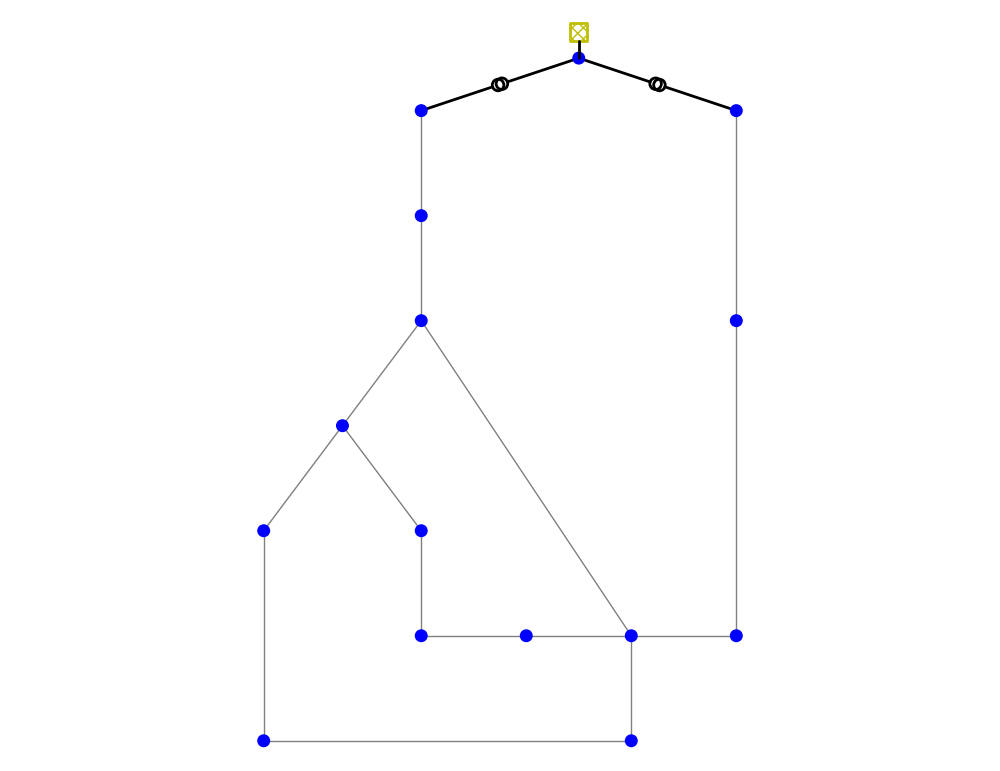

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 0: 负荷流未收敛，请检查输入数据或网络配置
时间步 1: 负荷流未收敛，请检查输入数据或网络配置
时间步 2: 负荷流未收敛，请检查输入数据或网络配置


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 3: 负荷流未收敛，请检查输入数据或网络配置
时间步 4: 负荷流未收敛，请检查输入数据或网络配置
时间步 5: 负荷流未收敛，请检查输入数据或网络配置
时间步 6: 负荷流未收敛，请检查输入数据或网络配置


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 7: 负荷流未收敛，请检查输入数据或网络配置
时间步 8: 负荷流未收敛，请检查输入数据或网络配置
时间步 9: 负荷流未收敛，请检查输入数据或网络配置
时间步 10: 负荷流未收敛，请检查输入数据或网络配置


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 11: 负荷流未收敛，请检查输入数据或网络配置
时间步 12: 负荷流未收敛，请检查输入数据或网络配置
时间步 13: 负荷流未收敛，请检查输入数据或网络配置


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 14: 负荷流未收敛，请检查输入数据或网络配置
时间步 15: 负荷流未收敛，请检查输入数据或网络配置
时间步 16: 负荷流未收敛，请检查输入数据或网络配置


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 17: 负荷流未收敛，请检查输入数据或网络配置
时间步 18: 负荷流未收敛，请检查输入数据或网络配置
时间步 19: 负荷流未收敛，请检查输入数据或网络配置
时间步 20: 负荷流未收敛，请检查输入数据或网络配置


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 21: 负荷流未收敛，请检查输入数据或网络配置
时间步 22: 负荷流未收敛，请检查输入数据或网络配置
时间步 23: 负荷流未收敛，请检查输入数据或网络配置


E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21387 (\N{CJK UNIFIED IDEOGRAPH-538B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27597 (\N{CJK UNIFIED IDEOGRAPH-6BCD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas

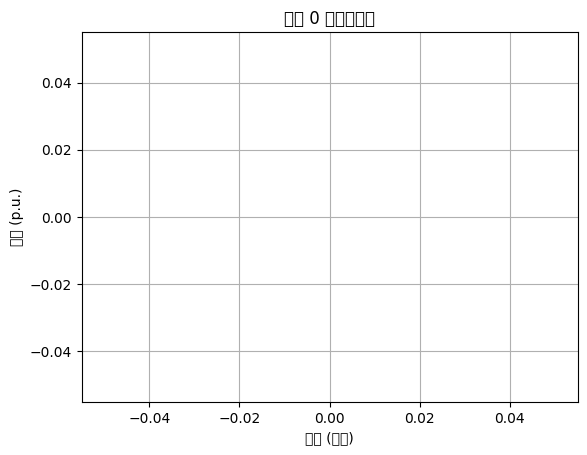

E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\software\miniconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36733 (\N{CJK UNIFIED IDEOGRAPH-8F7D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


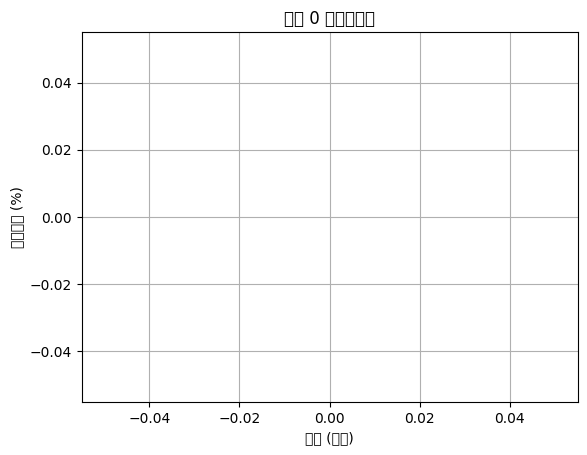

In [18]:
import pandapower as pp
import pandapower.networks as nw
import numpy as np
import matplotlib.pyplot as plt

# 加载 CIGRE 电网 (或使用自己的电网)
net = nw.create_cigre_network_mv()
pp.plotting.simple_plot(net, show_plot=True)  # 可视化网络

# 添加一个 0.4 MVA 20/0.4 kV 变压器
hv_bus = 5  # 假设高压母线编号是 5
lv_bus = pp.create_bus(net, vn_kv=0.4, geodata=(0, 6))  # 创建低压母线
pp.create_transformer(net, hv_bus, lv_bus, std_type="0.4 MVA 20/0.4 kV")

# 在低压母线处添加 EV 充电站
cs_load = pp.create_load(net, lv_bus, p_mw=0.1, q_mvar=0.02)  # 添加 EV 负载

# 给定的负荷曲线 (24 小时)
loadshape = np.array([0.28285, 0.272295, 0.2613828, 0.261328, 0.254316, 0.259789, 0.272966,
                      0.30915, 0.433979, 0.542955, 0.717333, 0.851829, 0.864118, 0.854116,
                      0.853815, 0.852508, 0.723452, 0.490362, 0.428271, 0.361402, 0.336596,
                      0.328176, 0.307331, 0.297966])

# 例如，对于 R1 负载，计算每日功率曲线
p_mw_r1 = 14.99400
q_mvar_r1 = 3.044662
load_profile_r1_p = loadshape * p_mw_r1
load_profile_r1_q = loadshape * q_mvar_r1

# 负荷缩放因子
scaling_factor = 0.5  # 负荷缩减一半
load_profile_r1_p *= scaling_factor
load_profile_r1_q *= scaling_factor

# 记录仿真结果
results = []

# 在24个时间步长内运行负荷流分析
for t in range(len(loadshape)):
    # 更新 R1 负载的功率值
    net.load.at[cs_load, 'p_mw'] = load_profile_r1_p[t]
    net.load.at[cs_load, 'q_mvar'] = load_profile_r1_q[t]

    # 尝试运行负荷流并处理可能的错误
    try:
        pp.runpp(net, max_iteration=50, tol=1e-5, algorithm='nr')
        print(f"时间步 {t}: 负荷流分析成功")

        # 存储结果 (例如，电压和线路负载)
        results.append({
            "time": t,
            "voltages": net.res_bus.vm_pu.values,
            "line_loading": net.res_line.loading_percent.values
        })

    except pp.LoadflowNotConverged:
        print(f"时间步 {t}: 负荷流未收敛，请检查输入数据或网络配置")
        # 将无效结果加入结果列表中，方便后续分析
        results.append({
            "time": t,
            "voltages": np.full(len(net.bus), np.nan),  # 用NaN表示无效数据
            "line_loading": np.full(len(net.line), np.nan)
        })

# 可视化母线电压随时间的变化
bus_index = 0  # 假设我们想分析母线 0
voltages_over_time = [result["voltages"][bus_index] for result in results]

plt.plot(np.arange(24), voltages_over_time)
plt.xlabel("时间 (小时)")
plt.ylabel("电压 (p.u.)")
plt.title(f"母线 {bus_index} 的电压变化")
plt.grid(True)
plt.show()

# 可视化线路负载随时间的变化
line_index = 0  # 假设我们想分析线路 0
line_loading_over_time = [result["line_loading"][line_index] for result in results]

plt.plot(np.arange(24), line_loading_over_time)
plt.xlabel("时间 (小时)")
plt.ylabel("线路负载 (%)")
plt.title(f"线路 {line_index} 的负载变化")
plt.grid(True)
plt.show()


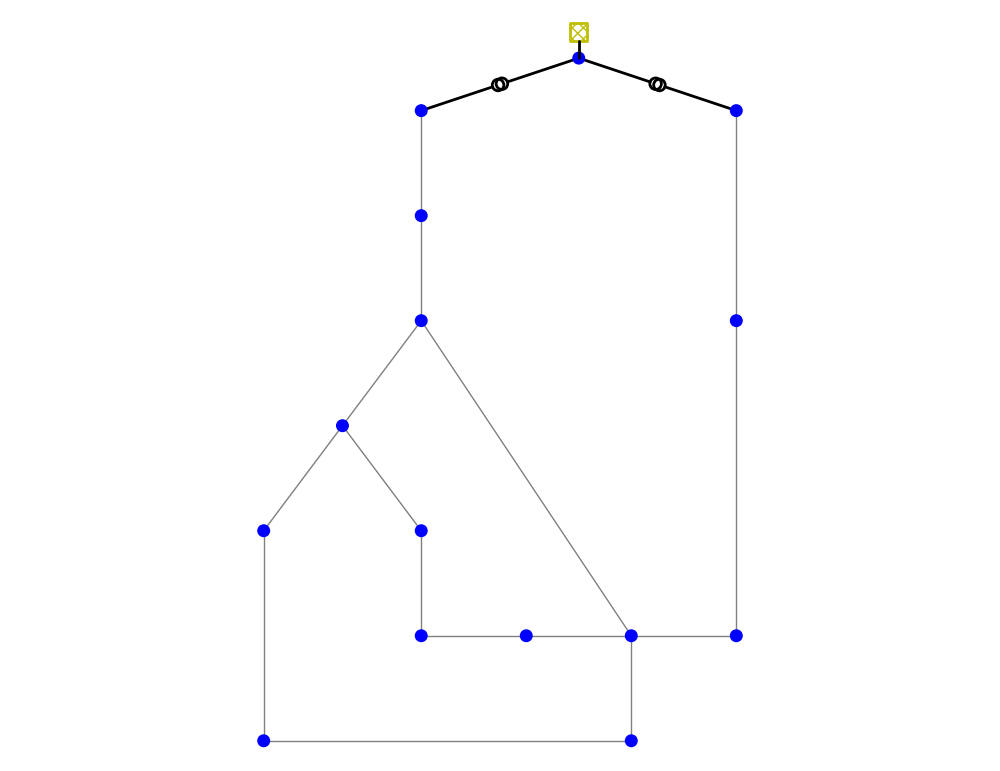

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba 

时间步 0 分钟: 负荷流未收敛
时间步 1 分钟: 负荷流未收敛
时间步 2 分钟: 负荷流未收敛
时间步 3 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 4 分钟: 负荷流未收敛
时间步 5 分钟: 负荷流未收敛
时间步 6 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 7 分钟: 负荷流未收敛
时间步 8 分钟: 负荷流未收敛
时间步 9 分钟: 负荷流未收敛
时间步 10 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 11 分钟: 负荷流未收敛
时间步 12 分钟: 负荷流未收敛
时间步 13 分钟: 负荷流未收敛
时间步 14 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 15 分钟: 负荷流未收敛
时间步 16 分钟: 负荷流未收敛
时间步 17 分钟: 负荷流未收敛
时间步 18 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 19 分钟: 负荷流未收敛
时间步 20 分钟: 负荷流未收敛
时间步 21 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 22 分钟: 负荷流未收敛
时间步 23 分钟: 负荷流未收敛
时间步 24 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 25 分钟: 负荷流未收敛
时间步 26 分钟: 负荷流未收敛
时间步 27 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 28 分钟: 负荷流未收敛
时间步 29 分钟: 负荷流未收敛
时间步 30 分钟: 负荷流未收敛
时间步 31 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 32 分钟: 负荷流未收敛
时间步 33 分钟: 负荷流未收敛
时间步 34 分钟: 负荷流未收敛
时间步 35 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 36 分钟: 负荷流未收敛
时间步 37 分钟: 负荷流未收敛
时间步 38 分钟: 负荷流未收敛
时间步 39 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 40 分钟: 负荷流未收敛
时间步 41 分钟: 负荷流未收敛
时间步 42 分钟: 负荷流未收敛
时间步 43 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 44 分钟: 负荷流未收敛
时间步 45 分钟: 负荷流未收敛
时间步 46 分钟: 负荷流未收敛
时间步 47 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 48 分钟: 负荷流未收敛
时间步 49 分钟: 负荷流未收敛
时间步 50 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 51 分钟: 负荷流未收敛
时间步 52 分钟: 负荷流未收敛
时间步 53 分钟: 负荷流未收敛
时间步 54 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba 

时间步 55 分钟: 负荷流未收敛
时间步 56 分钟: 负荷流未收敛
时间步 57 分钟: 负荷流未收敛
时间步 58 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 59 分钟: 负荷流未收敛
时间步 60 分钟: 负荷流未收敛
时间步 61 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 62 分钟: 负荷流未收敛
时间步 63 分钟: 负荷流未收敛
时间步 64 分钟: 负荷流未收敛
时间步 65 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 66 分钟: 负荷流未收敛
时间步 67 分钟: 负荷流未收敛
时间步 68 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 69 分钟: 负荷流未收敛
时间步 70 分钟: 负荷流未收敛
时间步 71 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 72 分钟: 负荷流未收敛
时间步 73 分钟: 负荷流未收敛
时间步 74 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 75 分钟: 负荷流未收敛
时间步 76 分钟: 负荷流未收敛
时间步 77 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 78 分钟: 负荷流未收敛
时间步 79 分钟: 负荷流未收敛
时间步 80 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 81 分钟: 负荷流未收敛
时间步 82 分钟: 负荷流未收敛
时间步 83 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 84 分钟: 负荷流未收敛
时间步 85 分钟: 负荷流未收敛
时间步 86 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 87 分钟: 负荷流未收敛
时间步 88 分钟: 负荷流未收敛
时间步 89 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 90 分钟: 负荷流未收敛
时间步 91 分钟: 负荷流未收敛
时间步 92 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 93 分钟: 负荷流未收敛
时间步 94 分钟: 负荷流未收敛
时间步 95 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 96 分钟: 负荷流未收敛
时间步 97 分钟: 负荷流未收敛
时间步 98 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 99 分钟: 负荷流未收敛
时间步 100 分钟: 负荷流未收敛
时间步 101 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 102 分钟: 负荷流未收敛
时间步 103 分钟: 负荷流未收敛
时间步 104 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 105 分钟: 负荷流未收敛
时间步 106 分钟: 负荷流未收敛
时间步 107 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 108 分钟: 负荷流未收敛
时间步 109 分钟: 负荷流未收敛
时间步 110 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 111 分钟: 负荷流未收敛
时间步 112 分钟: 负荷流未收敛
时间步 113 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 114 分钟: 负荷流未收敛
时间步 115 分钟: 负荷流未收敛
时间步 116 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 117 分钟: 负荷流未收敛
时间步 118 分钟: 负荷流未收敛
时间步 119 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 120 分钟: 负荷流未收敛
时间步 121 分钟: 负荷流未收敛
时间步 122 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 123 分钟: 负荷流未收敛
时间步 124 分钟: 负荷流未收敛
时间步 125 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 126 分钟: 负荷流未收敛
时间步 127 分钟: 负荷流未收敛
时间步 128 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 129 分钟: 负荷流未收敛
时间步 130 分钟: 负荷流未收敛
时间步 131 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 132 分钟: 负荷流未收敛
时间步 133 分钟: 负荷流未收敛
时间步 134 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 135 分钟: 负荷流未收敛
时间步 136 分钟: 负荷流未收敛
时间步 137 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 138 分钟: 负荷流未收敛
时间步 139 分钟: 负荷流未收敛
时间步 140 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 141 分钟: 负荷流未收敛
时间步 142 分钟: 负荷流未收敛
时间步 143 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 144 分钟: 负荷流未收敛
时间步 145 分钟: 负荷流未收敛
时间步 146 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 147 分钟: 负荷流未收敛
时间步 148 分钟: 负荷流未收敛
时间步 149 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 150 分钟: 负荷流未收敛
时间步 151 分钟: 负荷流未收敛
时间步 152 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 153 分钟: 负荷流未收敛
时间步 154 分钟: 负荷流未收敛
时间步 155 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 156 分钟: 负荷流未收敛
时间步 157 分钟: 负荷流未收敛
时间步 158 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 159 分钟: 负荷流未收敛
时间步 160 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 161 分钟: 负荷流未收敛
时间步 162 分钟: 负荷流未收敛
时间步 163 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 164 分钟: 负荷流未收敛
时间步 165 分钟: 负荷流未收敛
时间步 166 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 167 分钟: 负荷流未收敛
时间步 168 分钟: 负荷流未收敛
时间步 169 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 170 分钟: 负荷流未收敛
时间步 171 分钟: 负荷流未收敛
时间步 172 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 173 分钟: 负荷流未收敛
时间步 174 分钟: 负荷流未收敛
时间步 175 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 176 分钟: 负荷流未收敛
时间步 177 分钟: 负荷流未收敛
时间步 178 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 179 分钟: 负荷流未收敛
时间步 180 分钟: 负荷流未收敛
时间步 181 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 182 分钟: 负荷流未收敛
时间步 183 分钟: 负荷流未收敛
时间步 184 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 185 分钟: 负荷流未收敛
时间步 186 分钟: 负荷流未收敛
时间步 187 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 188 分钟: 负荷流未收敛
时间步 189 分钟: 负荷流未收敛
时间步 190 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 191 分钟: 负荷流未收敛
时间步 192 分钟: 负荷流未收敛
时间步 193 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 194 分钟: 负荷流未收敛
时间步 195 分钟: 负荷流未收敛
时间步 196 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 197 分钟: 负荷流未收敛
时间步 198 分钟: 负荷流未收敛
时间步 199 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 200 分钟: 负荷流未收敛
时间步 201 分钟: 负荷流未收敛
时间步 202 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 203 分钟: 负荷流未收敛
时间步 204 分钟: 负荷流未收敛
时间步 205 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 206 分钟: 负荷流未收敛
时间步 207 分钟: 负荷流未收敛
时间步 208 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 209 分钟: 负荷流未收敛
时间步 210 分钟: 负荷流未收敛
时间步 211 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 212 分钟: 负荷流未收敛
时间步 213 分钟: 负荷流未收敛
时间步 214 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 215 分钟: 负荷流未收敛
时间步 216 分钟: 负荷流未收敛
时间步 217 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 218 分钟: 负荷流未收敛
时间步 219 分钟: 负荷流未收敛
时间步 220 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 221 分钟: 负荷流未收敛
时间步 222 分钟: 负荷流未收敛
时间步 223 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 224 分钟: 负荷流未收敛
时间步 225 分钟: 负荷流未收敛
时间步 226 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 227 分钟: 负荷流未收敛
时间步 228 分钟: 负荷流未收敛
时间步 229 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 230 分钟: 负荷流未收敛
时间步 231 分钟: 负荷流未收敛
时间步 232 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 233 分钟: 负荷流未收敛
时间步 234 分钟: 负荷流未收敛
时间步 235 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 236 分钟: 负荷流未收敛
时间步 237 分钟: 负荷流未收敛
时间步 238 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 239 分钟: 负荷流未收敛
时间步 240 分钟: 负荷流未收敛
时间步 241 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 242 分钟: 负荷流未收敛
时间步 243 分钟: 负荷流未收敛
时间步 244 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 245 分钟: 负荷流未收敛
时间步 246 分钟: 负荷流未收敛
时间步 247 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 248 分钟: 负荷流未收敛
时间步 249 分钟: 负荷流未收敛
时间步 250 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 251 分钟: 负荷流未收敛
时间步 252 分钟: 负荷流未收敛
时间步 253 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 254 分钟: 负荷流未收敛
时间步 255 分钟: 负荷流未收敛
时间步 256 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 257 分钟: 负荷流未收敛
时间步 258 分钟: 负荷流未收敛
时间步 259 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 260 分钟: 负荷流未收敛
时间步 261 分钟: 负荷流未收敛
时间步 262 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 263 分钟: 负荷流未收敛
时间步 264 分钟: 负荷流未收敛
时间步 265 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 266 分钟: 负荷流未收敛
时间步 267 分钟: 负荷流未收敛
时间步 268 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 269 分钟: 负荷流未收敛
时间步 270 分钟: 负荷流未收敛
时间步 271 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 272 分钟: 负荷流未收敛
时间步 273 分钟: 负荷流未收敛
时间步 274 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 275 分钟: 负荷流未收敛
时间步 276 分钟: 负荷流未收敛
时间步 277 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 278 分钟: 负荷流未收敛
时间步 279 分钟: 负荷流未收敛
时间步 280 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 281 分钟: 负荷流未收敛
时间步 282 分钟: 负荷流未收敛
时间步 283 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 284 分钟: 负荷流未收敛
时间步 285 分钟: 负荷流未收敛
时间步 286 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 287 分钟: 负荷流未收敛
时间步 288 分钟: 负荷流未收敛
时间步 289 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 290 分钟: 负荷流未收敛
时间步 291 分钟: 负荷流未收敛
时间步 292 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 293 分钟: 负荷流未收敛
时间步 294 分钟: 负荷流未收敛
时间步 295 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 296 分钟: 负荷流未收敛
时间步 297 分钟: 负荷流未收敛
时间步 298 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 299 分钟: 负荷流未收敛
时间步 300 分钟: 负荷流未收敛
时间步 301 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 302 分钟: 负荷流未收敛
时间步 303 分钟: 负荷流未收敛
时间步 304 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 305 分钟: 负荷流未收敛
时间步 306 分钟: 负荷流未收敛
时间步 307 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 308 分钟: 负荷流未收敛
时间步 309 分钟: 负荷流未收敛
时间步 310 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 311 分钟: 负荷流未收敛
时间步 312 分钟: 负荷流未收敛
时间步 313 分钟: 负荷流未收敛
时间步 314 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 315 分钟: 负荷流未收敛
时间步 316 分钟: 负荷流未收敛
时间步 317 分钟: 负荷流未收敛
时间步 318 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 319 分钟: 负荷流未收敛
时间步 320 分钟: 负荷流未收敛
时间步 321 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 322 分钟: 负荷流未收敛
时间步 323 分钟: 负荷流未收敛
时间步 324 分钟: 负荷流未收敛
时间步 325 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 326 分钟: 负荷流未收敛
时间步 327 分钟: 负荷流未收敛
时间步 328 分钟: 负荷流未收敛
时间步 329 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 330 分钟: 负荷流未收敛
时间步 331 分钟: 负荷流未收敛
时间步 332 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 333 分钟: 负荷流未收敛
时间步 334 分钟: 负荷流未收敛
时间步 335 分钟: 负荷流未收敛
时间步 336 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 337 分钟: 负荷流未收敛
时间步 338 分钟: 负荷流未收敛
时间步 339 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 340 分钟: 负荷流未收敛
时间步 341 分钟: 负荷流未收敛
时间步 342 分钟: 负荷流未收敛
时间步 343 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 344 分钟: 负荷流未收敛
时间步 345 分钟: 负荷流未收敛
时间步 346 分钟: 负荷流未收敛
时间步 347 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 348 分钟: 负荷流未收敛
时间步 349 分钟: 负荷流未收敛
时间步 350 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 351 分钟: 负荷流未收敛
时间步 352 分钟: 负荷流未收敛
时间步 353 分钟: 负荷流未收敛
时间步 354 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 355 分钟: 负荷流未收敛
时间步 356 分钟: 负荷流未收敛
时间步 357 分钟: 负荷流未收敛
时间步 358 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 359 分钟: 负荷流未收敛
时间步 360 分钟: 负荷流未收敛
时间步 361 分钟: 负荷流未收敛
时间步 362 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 363 分钟: 负荷流未收敛
时间步 364 分钟: 负荷流未收敛
时间步 365 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 366 分钟: 负荷流未收敛
时间步 367 分钟: 负荷流未收敛
时间步 368 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 369 分钟: 负荷流未收敛
时间步 370 分钟: 负荷流未收敛
时间步 371 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 372 分钟: 负荷流未收敛
时间步 373 分钟: 负荷流未收敛
时间步 374 分钟: 负荷流未收敛
时间步 375 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba 

时间步 376 分钟: 负荷流未收敛
时间步 377 分钟: 负荷流未收敛
时间步 378 分钟: 负荷流未收敛
时间步 379 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 380 分钟: 负荷流未收敛
时间步 381 分钟: 负荷流未收敛
时间步 382 分钟: 负荷流未收敛
时间步 383 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 384 分钟: 负荷流未收敛
时间步 385 分钟: 负荷流未收敛
时间步 386 分钟: 负荷流未收敛
时间步 387 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 388 分钟: 负荷流未收敛
时间步 389 分钟: 负荷流未收敛
时间步 390 分钟: 负荷流未收敛
时间步 391 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 392 分钟: 负荷流未收敛
时间步 393 分钟: 负荷流未收敛
时间步 394 分钟: 负荷流未收敛
时间步 395 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 396 分钟: 负荷流未收敛
时间步 397 分钟: 负荷流未收敛
时间步 398 分钟: 负荷流未收敛
时间步 399 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 400 分钟: 负荷流未收敛
时间步 401 分钟: 负荷流未收敛
时间步 402 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 403 分钟: 负荷流未收敛
时间步 404 分钟: 负荷流未收敛
时间步 405 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 406 分钟: 负荷流未收敛
时间步 407 分钟: 负荷流未收敛
时间步 408 分钟: 负荷流未收敛
时间步 409 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 410 分钟: 负荷流未收敛
时间步 411 分钟: 负荷流未收敛
时间步 412 分钟: 负荷流未收敛
时间步 413 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 414 分钟: 负荷流未收敛
时间步 415 分钟: 负荷流未收敛
时间步 416 分钟: 负荷流未收敛
时间步 417 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 418 分钟: 负荷流未收敛
时间步 419 分钟: 负荷流未收敛
时间步 420 分钟: 负荷流未收敛
时间步 421 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 422 分钟: 负荷流未收敛
时间步 423 分钟: 负荷流未收敛
时间步 424 分钟: 负荷流未收敛
时间步 425 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 426 分钟: 负荷流未收敛
时间步 427 分钟: 负荷流未收敛
时间步 428 分钟: 负荷流未收敛
时间步 429 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 430 分钟: 负荷流未收敛
时间步 431 分钟: 负荷流未收敛
时间步 432 分钟: 负荷流未收敛
时间步 433 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 434 分钟: 负荷流未收敛
时间步 435 分钟: 负荷流未收敛
时间步 436 分钟: 负荷流未收敛
时间步 437 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 438 分钟: 负荷流未收敛
时间步 439 分钟: 负荷流未收敛
时间步 440 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 441 分钟: 负荷流未收敛
时间步 442 分钟: 负荷流未收敛
时间步 443 分钟: 负荷流未收敛
时间步 444 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 445 分钟: 负荷流未收敛
时间步 446 分钟: 负荷流未收敛
时间步 447 分钟: 负荷流未收敛
时间步 448 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 449 分钟: 负荷流未收敛
时间步 450 分钟: 负荷流未收敛
时间步 451 分钟: 负荷流未收敛
时间步 452 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 453 分钟: 负荷流未收敛
时间步 454 分钟: 负荷流未收敛
时间步 455 分钟: 负荷流未收敛
时间步 456 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 457 分钟: 负荷流未收敛
时间步 458 分钟: 负荷流未收敛
时间步 459 分钟: 负荷流未收敛
时间步 460 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 461 分钟: 负荷流未收敛
时间步 462 分钟: 负荷流未收敛
时间步 463 分钟: 负荷流未收敛
时间步 464 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 465 分钟: 负荷流未收敛
时间步 466 分钟: 负荷流未收敛
时间步 467 分钟: 负荷流未收敛
时间步 468 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 469 分钟: 负荷流未收敛
时间步 470 分钟: 负荷流未收敛
时间步 471 分钟: 负荷流未收敛
时间步 472 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 473 分钟: 负荷流未收敛
时间步 474 分钟: 负荷流未收敛
时间步 475 分钟: 负荷流未收敛
时间步 476 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 477 分钟: 负荷流未收敛
时间步 478 分钟: 负荷流未收敛
时间步 479 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 480 分钟: 负荷流未收敛
时间步 481 分钟: 负荷流未收敛
时间步 482 分钟: 负荷流未收敛
时间步 483 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 484 分钟: 负荷流未收敛
时间步 485 分钟: 负荷流未收敛
时间步 486 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 487 分钟: 负荷流未收敛
时间步 488 分钟: 负荷流未收敛
时间步 489 分钟: 负荷流未收敛
时间步 490 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 491 分钟: 负荷流未收敛
时间步 492 分钟: 负荷流未收敛
时间步 493 分钟: 负荷流未收敛
时间步 494 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 495 分钟: 负荷流未收敛
时间步 496 分钟: 负荷流未收敛
时间步 497 分钟: 负荷流未收敛
时间步 498 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 499 分钟: 负荷流未收敛
时间步 500 分钟: 负荷流未收敛
时间步 501 分钟: 负荷流未收敛
时间步 502 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 503 分钟: 负荷流未收敛
时间步 504 分钟: 负荷流未收敛
时间步 505 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 506 分钟: 负荷流未收敛
时间步 507 分钟: 负荷流未收敛
时间步 508 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 509 分钟: 负荷流未收敛
时间步 510 分钟: 负荷流未收敛
时间步 511 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 512 分钟: 负荷流未收敛
时间步 513 分钟: 负荷流未收敛
时间步 514 分钟: 负荷流未收敛
时间步 515 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 516 分钟: 负荷流未收敛
时间步 517 分钟: 负荷流未收敛
时间步 518 分钟: 负荷流未收敛
时间步 519 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 520 分钟: 负荷流未收敛
时间步 521 分钟: 负荷流未收敛
时间步 522 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 523 分钟: 负荷流未收敛
时间步 524 分钟: 负荷流未收敛
时间步 525 分钟: 负荷流未收敛
时间步 526 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 527 分钟: 负荷流未收敛
时间步 528 分钟: 负荷流未收敛
时间步 529 分钟: 负荷流未收敛
时间步 530 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 531 分钟: 负荷流未收敛
时间步 532 分钟: 负荷流未收敛
时间步 533 分钟: 负荷流未收敛
时间步 534 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 535 分钟: 负荷流未收敛
时间步 536 分钟: 负荷流未收敛
时间步 537 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 538 分钟: 负荷流未收敛
时间步 539 分钟: 负荷流未收敛
时间步 540 分钟: 负荷流未收敛
时间步 541 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba 

时间步 542 分钟: 负荷流未收敛
时间步 543 分钟: 负荷流未收敛
时间步 544 分钟: 负荷流未收敛
时间步 545 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 546 分钟: 负荷流未收敛
时间步 547 分钟: 负荷流未收敛
时间步 548 分钟: 负荷流未收敛
时间步 549 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 550 分钟: 负荷流未收敛
时间步 551 分钟: 负荷流未收敛
时间步 552 分钟: 负荷流未收敛
时间步 553 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 554 分钟: 负荷流未收敛
时间步 555 分钟: 负荷流未收敛
时间步 556 分钟: 负荷流未收敛
时间步 557 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 558 分钟: 负荷流未收敛
时间步 559 分钟: 负荷流未收敛
时间步 560 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 561 分钟: 负荷流未收敛
时间步 562 分钟: 负荷流未收敛
时间步 563 分钟: 负荷流未收敛
时间步 564 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 565 分钟: 负荷流未收敛
时间步 566 分钟: 负荷流未收敛
时间步 567 分钟: 负荷流未收敛
时间步 568 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 569 分钟: 负荷流未收敛
时间步 570 分钟: 负荷流未收敛
时间步 571 分钟: 负荷流未收敛
时间步 572 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 573 分钟: 负荷流未收敛
时间步 574 分钟: 负荷流未收敛
时间步 575 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 576 分钟: 负荷流未收敛
时间步 577 分钟: 负荷流未收敛
时间步 578 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 579 分钟: 负荷流未收敛
时间步 580 分钟: 负荷流未收敛
时间步 581 分钟: 负荷流未收敛
时间步 582 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 583 分钟: 负荷流未收敛
时间步 584 分钟: 负荷流未收敛
时间步 585 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 586 分钟: 负荷流未收敛
时间步 587 分钟: 负荷流未收敛
时间步 588 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 589 分钟: 负荷流未收敛
时间步 590 分钟: 负荷流未收敛
时间步 591 分钟: 负荷流未收敛
时间步 592 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 593 分钟: 负荷流未收敛
时间步 594 分钟: 负荷流未收敛
时间步 595 分钟: 负荷流未收敛
时间步 596 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 597 分钟: 负荷流未收敛
时间步 598 分钟: 负荷流未收敛
时间步 599 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 600 分钟: 负荷流未收敛
时间步 601 分钟: 负荷流未收敛
时间步 602 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 603 分钟: 负荷流未收敛
时间步 604 分钟: 负荷流未收敛
时间步 605 分钟: 负荷流未收敛
时间步 606 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 607 分钟: 负荷流未收敛
时间步 608 分钟: 负荷流未收敛
时间步 609 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


时间步 610 分钟: 负荷流未收敛
时间步 611 分钟: 负荷流未收敛
时间步 612 分钟: 负荷流未收敛


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
